#Курсовой проект для курса "Python для Data Science"
#*Построение модели для предсказания цен на недвижимость в Москве*


## Требования к курсовому проекту

Нужно будет оформить ноутбук с основными этапами:
1. подготовка данных
    * анализ
    * визуализация
    * обработка выбросов
    * обработка пропусков
    * генерация фичей
2. обучение модели
3. проверка качества модели

Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Так же надо отправить файл с предсказаниями на kaggle и на private leaderboard получить больше 0.6

Данные для курсового можно брать отсюда https://www.kaggle.com/t/b4c9382d4f934176af9fe860b1976528 (вкладка data)

Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"),разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

## Подключение библиотек и скриптов


In [5]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})  # размер шрифта на графиках
%config InlineBackend.figure_format = 'svg'

**Пути к директориям и файлам**

In [6]:
# ВНИМАНИЕ! При запуске ноутбука на локальных ресурсах, использовать соответствующие для путей строки
# файлы при этом должны находиться в папке, где запускается j notebook
#TRAIN_DATASET_PATH = '/content/drive/MyDrive/Образование/Факультет ИИ/Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn/Course Project/train.csv'
#TEST_DATASET_PATH = '/content/drive/MyDrive/Образование/Факультет ИИ/Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn/Course Project/test.csv'
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

## Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

### Загрузка тренировочного набора данных

In [7]:
# данный код нужен только для подключения ресурсов google drive. 
# При локальном запуске - закомментировать. 
"""
from google.colab import drive
drive.mount('/content/drive')
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [8]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
9995   1260          61    2.0  49.090728   33.272626            6.0      3   
9996  16265          27    2.0  64.307684   37.038420            9.0     13   
9997   2795         178    1.0  29.648057   16.555363            5.0      3   
9998  14561          21    1.0  32.330292   22.326870            5.0      3   
9999   7202          94    1.0  35.815476   22.301367            6.0      9   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
9995        12.0       1981   0.300323         B         B        52   
9996         0.0       1977   0.072158         B         B         2   
9997         5.0       1958   0.460556         B         B        20   
9998         9.0       1969   0.194489         B         B        47   
9999         9.0       1975   0.127376         B         B        43   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
9995     10311         6           NaN            1        9       B   
9996       629         1           NaN            0        0       A   
9997      4386        14           NaN            1        5       B   
9998      8004         3         125.0            3        5       B   
9999      8429         3           NaN            3        9       B   

              Price  
9995  119367.455796  
9996  199715.148807  
9997  165953.912580  
9998  171842.411855  
9999  177685.627486

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

### Загрузка тестового набора данных

In [10]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
4995  10379          29    2.0  43.177521   30.339945            5.0      6   
4996  16138          38    3.0  93.698122   94.521465           10.0     21   
4997   3912         101    1.0  33.656723   19.003259            5.0      2   
4998   5722          10    1.0  38.635155   20.976257            9.0      8   
4999  11004          21    2.0  67.122742   33.944344           13.0      9   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
4995         5.0       1962   0.069660         B         B        31   
4996        27.0       2018   0.060753         B         B        15   
4997         5.0       1966   0.038693         B         B        28   
4998        14.0       1970   0.089040         B         B        33   
4999        17.0       2009   0.194489         B         B        47   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
4995      6119         4           NaN            1        2       B  
4996      2787         2         520.0            0        7       B  
4997      6533         1        1015.0            2        5       B  
4998      7976         5           NaN            0       11       B  
4999      8004         3         125.0            3        5       B

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

### Приведение типов

In [12]:
# Сделаем небольшие преобразования типов данных
# Id - не функциональный параметр, поэтому сделаем его пока строковым
train_df['Id'] = train_df['Id'].astype(str)
#train_df['DistrictId'] = train_df['DistrictId'].astype(str)
# количество комнат и этажей обычно выражаются целыми числами
train_df['Rooms'] = train_df['Rooms'].astype(int)
train_df['HouseFloor'] = train_df['HouseFloor'].astype(int)

In [13]:
train_df.dtypes

Id                object
DistrictId         int64
Rooms              int64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor         int64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

### Предварительный анализ данных

In [14]:
print("Предварительный анализ данных")
print(f'Общее количество строк в трейне: {train_df.shape[0]}')
print(f'Общее количество строк в тесте: {test_df.shape[0]}')
print(f"Количество числовых признаков, за исключением целевой переменной: \
{train_df.select_dtypes(include=['float64', 'float32', 'float16', 'int64', 'int32', 'int16']).shape[1]-1}")
print(f"Список количественных признаков: {train_df.select_dtypes(exclude='object').columns.tolist()[:-1]}")
print(f"Количество номинативных признаков: \
{train_df.select_dtypes(exclude=['float64', 'float32', 'float16', 'int64', 'int32', 'int16']).shape[1]}")
print(f"Список номинативных признаков: {train_df.select_dtypes(include='object').columns.tolist()}")
print()
print(f"Количество признаков в тренировочном и тестовом наборах{'' if train_df.shape[1] - 1 == test_df.shape[1] else 'не'} совпадают")


Предварительный анализ данных
Общее количество строк в трейне: 10000
Общее количество строк в тесте: 5000
Количество числовых признаков, за исключением целевой переменной: 15
Список количественных признаков: ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1']
Количество номинативных признаков: 4
Список номинативных признаков: ['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']

Количество признаков в тренировочном и тестовом наборах совпадают


## 1. Анализ данных (EDA)

**Распределение целевой переменной**

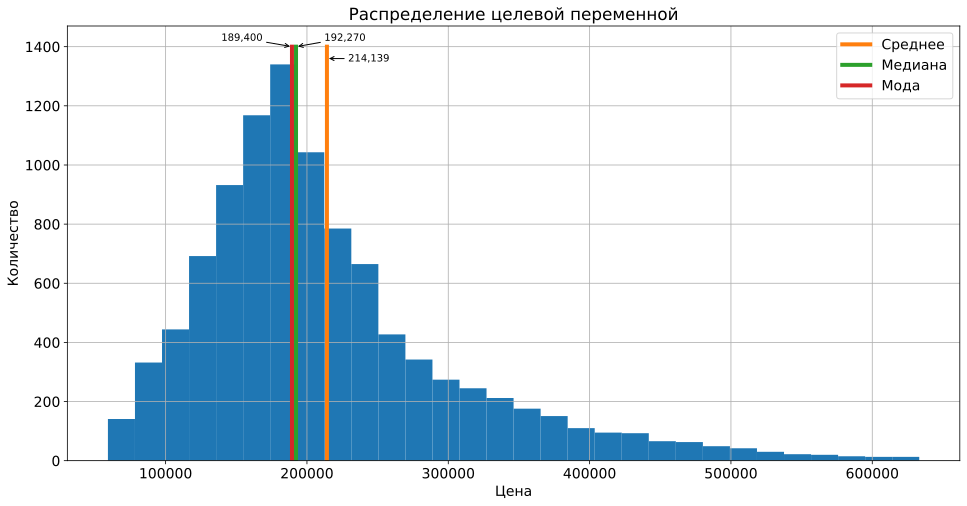

In [15]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
# перед тем как считать наиболее часто встречающееся значение целевой переменной (mode), округлим ее до 100
# в противном случае, количество значений в mode = количеству записей в датасете, то есть значение моды становится нерелевантной
target_mode = (train_df['Price']//100 * 100).mode()[0]

plt.figure(figsize = (16, 8))

train_df.Price.hist(bins=30)

y = np.linspace(0, 1400, 10)
plt.plot([target_mean] * 10, y, label='Среднее',  linewidth=4)
plt.plot([target_median] * 10, y, label='Медиана',  linewidth=4)
plt.plot([target_mode] * 10, y, label='Мода', linewidth=4)
# метод annotate позволяет комментировать графики.
plt.annotate("{:,.0f}".format(target_mean), xy=[target_mean,1360], fontsize=10, xytext=[target_mean +15000,1350], arrowprops=dict(arrowstyle="->"))
plt.annotate("{:,.0f}".format(round(target_median)), xy=[target_median,1400], fontsize=10, xytext=[target_median + 20000,1420], arrowprops=dict(arrowstyle="->"))
plt.annotate("{:,.0f}".format(round(target_mode)), xy=[target_mode,1400], fontsize=10, xytext=[target_mode - 50000,1420], arrowprops=dict(arrowstyle="->"))

plt.ylabel('Количество')
plt.xlabel('Цена')
plt.legend()

plt.title('Распределение целевой переменной')
plt.show()


Распределение целевой переменной выглядит нормально, явных выбросов нет, значение среднего, медианы и моды вполне согласованы.

**Анализ количественных переменных**

In [16]:
train_df.describe()

DistrictId         Rooms        Square   LifeSquare  KitchenSquare  \
count  10000.000000  10000.000000  10000.000000  7887.000000   10000.000000   
mean      50.400800      1.890500     56.315775    37.199645       6.273300   
std       43.587592      0.839512     21.058732    86.241209      28.560917   
min        0.000000      0.000000      1.136859     0.370619       0.000000   
25%       20.000000      1.000000     41.774881    22.769832       1.000000   
50%       36.000000      2.000000     52.513310    32.781260       6.000000   
75%       75.000000      2.000000     65.900625    45.128803       9.000000   
max      209.000000     19.000000    641.065193  7480.592129    2014.000000   

              Floor    HouseFloor     HouseYear     Ecology_1      Social_1  \
count  10000.000000  10000.000000  1.000000e+04  10000.000000  10000.000000   
mean       8.526700     12.609400  3.990166e+03      0.118858     24.687000   
std        5.241148      6.775974  2.005003e+05      0.119025     17.532614   
min        1.000000      0.000000  1.910000e+03      0.000000      0.000000   
25%        4.000000      9.000000  1.974000e+03      0.017647      6.000000   
50%        7.000000     13.000000  1.977000e+03      0.075424     25.000000   
75%       12.000000     17.000000  2.001000e+03      0.195781     36.000000   
max       42.000000    117.000000  2.005201e+07      0.521867     74.000000   

           Social_2      Social_3  Healthcare_1   Helthcare_2       Shops_1  \
count  10000.000000  10000.000000   5202.000000  10000.000000  10000.000000   
mean    5352.157400      8.039200   1142.904460      1.319500      4.231300   
std     4006.799803     23.831875   1021.517264      1.493601      4.806341   
min      168.000000      0.000000      0.000000      0.000000      0.000000   
25%     1564.000000      0.000000    350.000000      0.000000      1.000000   
50%     5285.000000      2.000000    900.000000      1.000000      3.000000   
75%     7227.000000      5.000000   1548.000000      2.000000      6.000000   
max    19083.000000    141.000000   4849.000000      6.000000     23.000000   

               Price  
count   10000.000000  
mean   214138.857399  
std     92872.293865  
min     59174.778028  
25%    153872.633942  
50%    192269.644879  
75%    249135.462171  
max    633233.466570

Что видим?


1.   Странные значения для количества комнат, Rooms: 
  *   Минимум = 0 (?!)
  *   Максимум = 19 (?!)
2.   Общая площадь, Square:
  *   Не заполненных значений - нет
  *   странные значения минимума, мин = 1.13 (?!)
  *   и максимума, max = 641 (?!)
3. Жилая площадь, LifeSquare: 
  *   **Не заполненные значения - есть!**
  *   странные значения минимума: мин = 0.3 (?!)
  *   и максимума: max = 7 480 (?!)
  *   **Нужно проверить есть случаи, когда жилая площадь больше общей!**
4. Странные значения площади кухни: 
  *   мин = 0.0 (?!)
  *   max = 2 014 (?!)
5. Странные значения этажности дома, HouseFloor:
  *   min = 0
  *   max = 117
  *   **Нужно проверить - есть ли случаи, когда этажность дома меньше, чем этаж квартиры**
6. Страные значения года постройки дома:
  *   max = 2.005201e+07 (?!)
7. Показатель, связанный с охраной здоровья, Healthcare_1:
  *   **Есть пропуски в данных, почти половина!**
















**Анализ номинативных переменных**

In [17]:
# Список номинативных переменных
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [18]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [19]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [20]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Признаки *Ecology_2*, *Ecology_3*, *Shop_2* имеют всего два значения. Значения явно не сбалансированы (потенциальные кандидаты на выбросы?). Имеет смысл перевести их в числовой вид. 

In [21]:
# переведем оставшиеся номинативные признаки в числовой вид
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

Посмотрим на корреляцию признаков

In [22]:
# строим матрицу корреляций
train_df_corr = train_df.corr()
train_df_corr

DistrictId     Rooms    Square  LifeSquare  KitchenSquare  \
DistrictId       1.000000  0.071432 -0.026613   -0.019910       0.040358   
Rooms            0.071432  1.000000  0.662893    0.131336       0.005123   
Square          -0.026613  0.662893  1.000000    0.196129       0.008320   
LifeSquare      -0.019910  0.131336  0.196129    1.000000      -0.001195   
KitchenSquare    0.040358  0.005123  0.008320   -0.001195       1.000000   
Floor           -0.120373 -0.000665  0.114791    0.024559      -0.011397   
HouseFloor      -0.149051 -0.029302  0.081505    0.027442       0.000780   
HouseYear        0.013430 -0.010612 -0.009032   -0.002210       0.000958   
Ecology_1        0.065294 -0.032347 -0.064479   -0.023629      -0.005622   
Ecology_2       -0.093406 -0.001971  0.029926    0.006808       0.000268   
Ecology_3       -0.027902 -0.005909  0.022748    0.008597      -0.007919   
Social_1         0.246463  0.075980 -0.070690   -0.048363       0.043379   
Social_2         0.167479  0.071335 -0.043120   -0.039283       0.037805   
Social_3         0.136095  0.012811  0.035241    0.012763      -0.015140   
Healthcare_1     0.304335  0.042857 -0.039748   -0.026867       0.009472   
Helthcare_2      0.306147  0.063557 -0.022960   -0.024762       0.043170   
Shops_1          0.174214  0.053618  0.021357   -0.007569       0.010216   
Shops_2         -0.021018 -0.000146 -0.049380   -0.004692      -0.017315   
Price            0.265100  0.550291  0.520075    0.081292       0.028864   

                  Floor  HouseFloor  HouseYear  Ecology_1  Ecology_2  \
DistrictId    -0.120373   -0.149051   0.013430   0.065294  -0.093406   
Rooms         -0.000665   -0.029302  -0.010612  -0.032347  -0.001971   
Square         0.114791    0.081505  -0.009032  -0.064479   0.029926   
LifeSquare     0.024559    0.027442  -0.002210  -0.023629   0.006808   
KitchenSquare -0.011397    0.000780   0.000958  -0.005622   0.000268   
Floor          1.000000    0.418986   0.000928  -0.016133   0.049661   
HouseFloor     0.418986    1.000000  -0.000864  -0.004362   0.059347   
HouseYear      0.000928   -0.000864   1.000000   0.001465   0.000997   
Ecology_1     -0.016133   -0.004362   0.001465   1.000000  -0.110725   
Ecology_2      0.049661    0.059347   0.000997  -0.110725   1.000000   
Ecology_3      0.025767    0.009258   0.001686  -0.223197  -0.016643   
Social_1      -0.044914   -0.020801   0.003026   0.026464  -0.066017   
Social_2      -0.016560    0.007194   0.001970   0.009264  -0.012709   
Social_3      -0.002237   -0.008137   0.000819  -0.124068   0.008512   
Healthcare_1  -0.138294   -0.143973  -0.011969  -0.043547  -0.031724   
Helthcare_2   -0.065537   -0.068728   0.011245   0.030873  -0.082667   
Shops_1        0.024264    0.026279   0.003681  -0.076749   0.051892   
Shops_2       -0.013626    0.051002   0.002994   0.079809   0.022242   
Price          0.128715    0.088280   0.004305  -0.058381   0.022379   

               Ecology_3  Social_1  Social_2  Social_3  Healthcare_1  \
DistrictId     -0.027902  0.246463  0.167479  0.136095      0.304335   
Rooms          -0.005909  0.075980  0.071335  0.012811      0.042857   
Square          0.022748 -0.070690 -0.043120  0.035241     -0.039748   
LifeSquare      0.008597 -0.048363 -0.039283  0.012763     -0.026867   
KitchenSquare  -0.007919  0.043379  0.037805 -0.015140      0.009472   
Floor           0.025767 -0.044914 -0.016560 -0.002237     -0.138294   
HouseFloor      0.009258 -0.020801  0.007194 -0.008137     -0.143973   
HouseYear       0.001686  0.003026  0.001970  0.000819     -0.011969   
Ecology_1      -0.223197  0.026464  0.009264 -0.124068     -0.043547   
Ecology_2      -0.016643 -0.066017 -0.012709  0.008512     -0.031724   
Ecology_3       1.000000 -0.037777  0.007394  0.014595     -0.114715   
Social_1       -0.037777  1.000000  0.955988  0.023721      0.077133   
Social_2        0.007394  0.955988  1.000000  0.073379      0.050458   
Social_3        0.014595  0.023721  0.073379 

Посмотрим на матрицу корреляций

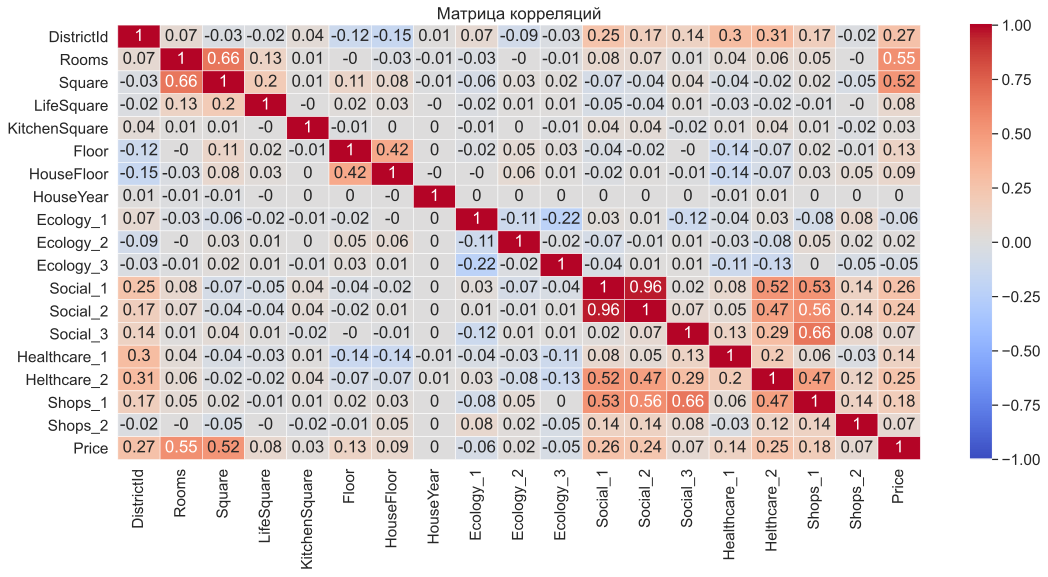

In [23]:
plt.figure(figsize = (18,8))

sns.set(font_scale=1.4)

corr_matrix = np.round(train_df_corr, 2)

#sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm', vmin=-1, vmax=1)
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Матрица корреляций')
plt.show()

Видно, что признаки Social_1 и Social_2 имеют кэфициент корреляции - 0,96. Это означает, что потенциально можно оставить только один признак для расчетов. Так же видно, что Shops_1 довольно сильно связан с параметрами Social_1, Social_2,Social_3, а также с Helthcare_2. Потенциально, можно подумать как уменьшить количество взаимосвязанных параметров.  

## 2. Обработка выбросов

**Rooms**

1.   Странные значения для количества комнат, Rooms: 
  *   Минимум = 0 (?!)
  *   Максимум = 19 (?!)

In [24]:
# посмотрим какие значения количества комнат встречаются и как часто
train_df['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
6        1
19       1
Name: Rooms, dtype: int64

In [25]:
# посмотрим на статистику
train_df.describe()

DistrictId         Rooms        Square   LifeSquare  KitchenSquare  \
count  10000.000000  10000.000000  10000.000000  7887.000000   10000.000000   
mean      50.400800      1.890500     56.315775    37.199645       6.273300   
std       43.587592      0.839512     21.058732    86.241209      28.560917   
min        0.000000      0.000000      1.136859     0.370619       0.000000   
25%       20.000000      1.000000     41.774881    22.769832       1.000000   
50%       36.000000      2.000000     52.513310    32.781260       6.000000   
75%       75.000000      2.000000     65.900625    45.128803       9.000000   
max      209.000000     19.000000    641.065193  7480.592129    2014.000000   

              Floor    HouseFloor     HouseYear     Ecology_1     Ecology_2  \
count  10000.000000  10000.000000  1.000000e+04  10000.000000  10000.000000   
mean       8.526700     12.609400  3.990166e+03      0.118858      0.990300   
std        5.241148      6.775974  2.005003e+05      0.119025      0.098015   
min        1.000000      0.000000  1.910000e+03      0.000000      0.000000   
25%        4.000000      9.000000  1.974000e+03      0.017647      1.000000   
50%        7.000000     13.000000  1.977000e+03      0.075424      1.000000   
75%       12.000000     17.000000  2.001000e+03      0.195781      1.000000   
max       42.000000    117.000000  2.005201e+07      0.521867      1.000000   

          Ecology_3      Social_1      Social_2      Social_3  Healthcare_1  \
count  10000.000000  10000.000000  10000.000000  10000.000000   5202.000000   
mean       0.972500     24.687000   5352.157400      8.039200   1142.904460   
std        0.163543     17.532614   4006.799803     23.831875   1021.517264   
min        0.000000      0.000000    168.000000      0.000000      0.000000   
25%        1.000000      6.000000   1564.000000      0.000000    350.000000   
50%        1.000000     25.000000   5285.000000      2.000000    900.000000   
75%        1.000000     36.000000   7227.000000      5.000000   1548.000000   
max        1.000000     74.000000  19083.000000    141.000000   4849.000000   

        Helthcare_2       Shops_1       Shops_2          Price  
count  10000.000000  10000.000000  10000.000000   10000.000000  
mean       1.319500      4.231300      0.917500  214138.857399  
std        1.493601      4.806341      0.275139   92872.293865  
min        0.000000      0.000000      0.000000   59174.778028  
25%        0.000000      1.000000      1.000000  153872.633942  
50%        1.000000      3.000000      1.000000  192269.644879  
75%        2.000000      6.000000      1.000000  249135.462171  
max        6.000000     23.000000      1.000000  633233.466570

In [26]:
#train_df.loc[(train_df['Rooms'] == 2), ['Price']].describe()
train_df.loc[(train_df['Rooms'] >= 6) | (train_df['Rooms'] == 0)]

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
2004   5927          57     10   59.056975   36.223072           10.0     22   
2194   3159          88      0   38.697117   19.345131            9.0      9   
2728  14865           9     10   60.871266   38.420681           10.0      3   
3780   7317          27      0   41.790881         NaN            0.0     13   
5894    770          28      0   49.483501         NaN            0.0     16   
6088   8491           1     19   42.006046   21.779288            7.0     17   
6401   9443          27      0   87.762616   85.125471            0.0      5   
7644   7917          27      0  212.932361  211.231125            0.0      2   
7929    456           6      0   81.491446         NaN            0.0      4   
8794  14003          99      6   59.414334   38.702244            6.0      7   
9767  12638          27      0  138.427694  136.215499            0.0      4   
9869   3224          27      0    2.377248    0.873147            0.0      1   

      HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  \
2004          22       2002   0.090799          1          1        74   
2194          16       1982   0.127376          1          1        43   
2728           2       1994   0.161532          1          1        25   
3780           0       1977   0.211401          1          1         9   
5894           0       2015   0.118537          1          1        30   
6088          17       2014   0.007122          1          1         1   
6401          15       1977   0.211401          1          1         9   
7644           3       2008   0.211401          1          1         9   
7929           0       1977   0.243205          1          1         5   
8794           9       1969   0.033494          1          1        66   
9767           3       2016   0.075424          1          1        11   
9869           0       1977   0.017647          1          1         2   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2  \
2004     19083         2           NaN            5       15        1   
2194      8429         3           NaN            3        9        1   
2728      5648         1          30.0            2        4        1   
3780      1892         0           NaN            0        1        1   
5894      6207         1        1183.0            1        0        1   
6088       264         0           NaN            0        1        1   
6401      1892         0           NaN            0        1        1   
7644      1892         0           NaN            0        1        1   
7929      1564         0         540.0            0        0        1   
8794     10573         1        1322.0            3        8        1   
9767      3097         0           NaN            0        0        1   
9869       469         0           NaN            0        0        1   

              Price  
2004  317265.323792  
2194  158998.110646  
2728  172329.270863  
3780   98129.976788  
5894  217009.338463  
6088   78364.616704  
6401  219281.918007  
7644  302211.260887  
7929  212864.799112  
8794  229661.964416  
9767  268394.744389  
9869  126596.941798

По количеству комнат (признаку Rooms) у нас всего 12 выбросов. Нет смысла добавлять дополнительный параметр - выброс признаку Rooms.

In [27]:
# присвоим значение медианы по количеству комнат всем выбросам
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms'] = train_df['Rooms'].median()
train_df['Rooms'].value_counts()

2    3892
1    3705
3    2235
4     150
5      18
Name: Rooms, dtype: int64

Количество комнат в датасете теперь выглядит правдоподобно

**Square**

2.   Общая площадь, Square:
  *   Не заполненных значений - нет
  *   странные значения минимума, мин = 1.13 (?!)
  *   и максимума, max = 641 (?!)

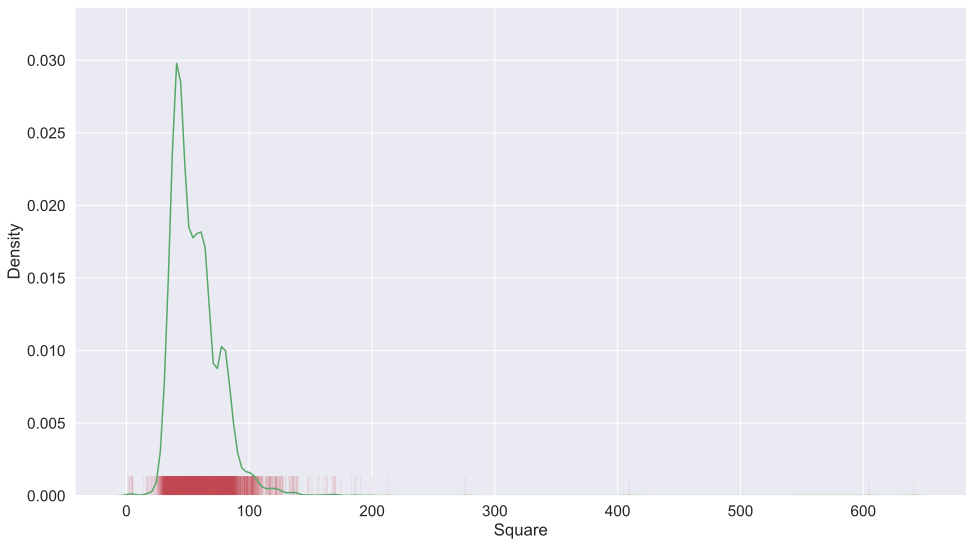

In [28]:
# посмотрим на распределение признака Square
plt.figure(figsize=(16, 9))

h_kws={"alpha": 0.5, "color": "r"}
k_kws={ "shade": False, "color": "g"}
r_kws={"alpha": 0.1, "height":0.04, "color": "r"}
sns.distplot(train_df['Square'], bins=50, rug=True, hist=False, hist_kws=h_kws, kde_kws=k_kws, rug_kws=r_kws)

plt.xlabel('Square')
plt.show()

In [29]:
# приблизительное распределение в числах
(train_df['Square'] // 10 * 10).value_counts()

40.0     2824
30.0     1732
50.0     1693
60.0     1625
70.0      914
80.0      678
90.0      167
100.0     124
20.0       84
110.0      46
120.0      40
130.0      22
0.0        12
10.0        9
160.0       9
140.0       4
150.0       3
170.0       3
180.0       3
190.0       2
640.0       1
210.0       1
600.0       1
400.0       1
270.0       1
200.0       1
Name: Square, dtype: int64

In [30]:
# посмотрим на потенциальные выбросы: площадь больше 180.
temp_df = train_df.loc[train_df['Square'] > 180, ['Square', 'Price', 'Rooms', 'HouseYear']]
temp_df.sort_values(by='Square', ascending=False)

Square          Price  Rooms  HouseYear
9229  641.065193  133529.681562      2       2019
726   604.705972  187717.242538      2       1977
7010  409.425181   90470.430830      1       2016
1906  275.645284  455264.882666      5       2011
7644  212.932361  302211.260887      2       2008
1776  200.334539  528560.506016      4       2013
9307  198.930182  345665.209100      5       2011
1606  190.857689  338644.075979      3       2007
8011  186.692602  423443.464367      4       2011
2790  185.906396  340273.238253      4       2015
403   183.382273  622888.825328      5       1997

In [31]:
train_df.loc[train_df['Square'] > 130, ['Square', 'Price']].describe()

Square          Price
count   52.000000      52.000000
mean   179.609667  282472.244000
std     99.814215  139241.601749
min    132.474700   90470.430830
25%    136.445992  186247.195132
50%    149.911299  211253.185930
75%    170.107527  347291.145818
max    641.065193  622888.825328

Можно предположить, что значения площади после 275 - это выбросы.

In [32]:
# посчитаем статистику по признаку Square
train_df['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

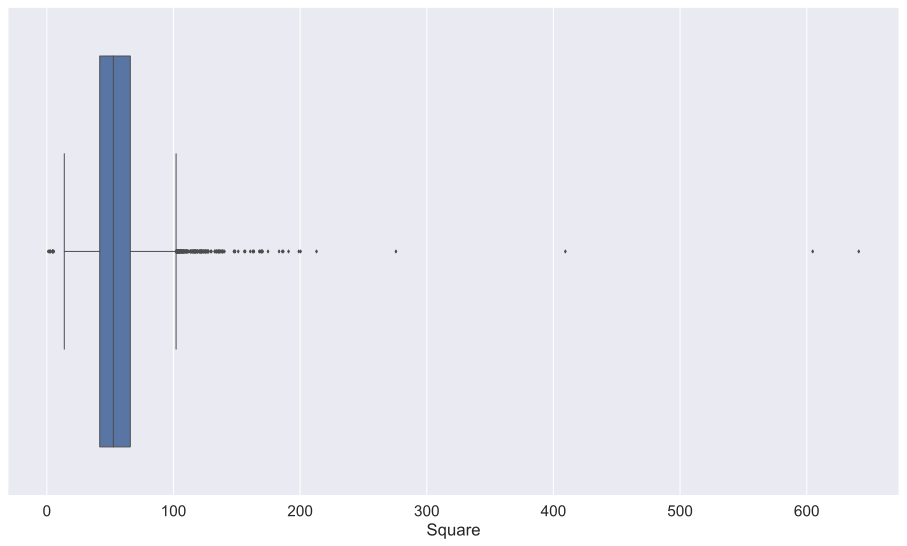

In [33]:
plt.figure(figsize=(16, 9))

sns.boxplot(train_df['Square'],  linewidth=1, fliersize=2, whis=1.5)

plt.xlabel('Square')
plt.show()

In [34]:
# посчитаем межквартильный размах для общей площади, и максимальное и минимальное значения (значения "усов")
quart_range = train_df['Square'].quantile(.75) - train_df['Square'].quantile(.25)
whis, dev = 1.5, 0.5
min_quart = train_df['Square'].quantile(.25) - (quart_range * (whis - dev))
max_quart = train_df['Square'].quantile(.75) + (quart_range * (whis + dev))

In [35]:
quart_range, min_quart, max_quart

(24.125744426186976, 17.64913639328286, 114.15211409803076)

Оптимизируем значения общей площади, то есть обработаем выбросы:
Потенциально есть следующие варианты:
1.   На базе статистики, используя значения межквартильных размахов присвоить значения больше максимального либо медианному значению, либо максимальному. 
2.   На базе экспертного мнения, принять максимальное значение площади 200 и для больших значений присвоить либо медиану, либо максимум.
3. Тоже самое и для минимальных значений



In [36]:
# Присвоим значение общей площади для значений выше 200 = 200 или 
# Присвоим значение общей площади для значений, выше 2х межквартильных размахов = значению максимального 2* межвартильного размаха
#train_df.loc[(train_df['Square'] > 200), 'Square'] = 200
train_df.loc[(train_df['Square'] > max_quart), 'Square'] = max_quart


In [37]:
# Присвоим значение общей площади для значений меньше 20 = 20
# Присвоим значение общей площади для значений меньше минимум от одного межквартильного размаха
# train_df.loc[(train_df['Square'] < 20), 'Square'] = 20
train_df.loc[(train_df['Square'] < min_quart), 'Square'] = min_quart

Посмотрим на распределение значений общей площади после оптимизации

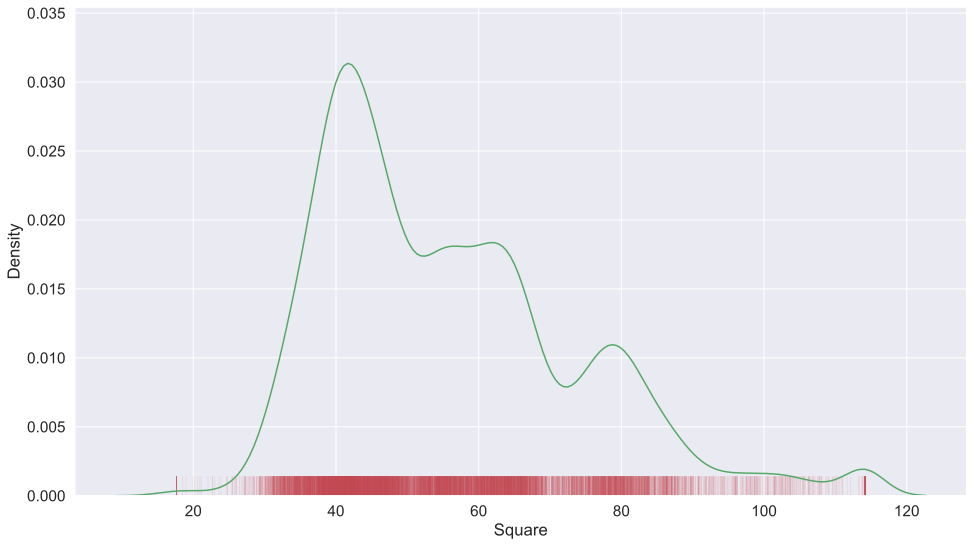

In [38]:
plt.figure(figsize=(16, 9))

h_kws={"alpha": 0.5, "color": "r"}
k_kws={ "shade": False, "color": "g"}
r_kws={"alpha": 0.1, "height":0.04, "color": "r"}
sns.distplot(train_df['Square'], bins=50, rug=True, hist=False, hist_kws=h_kws, kde_kws=k_kws, rug_kws=r_kws)

plt.xlabel('Square')
plt.show()

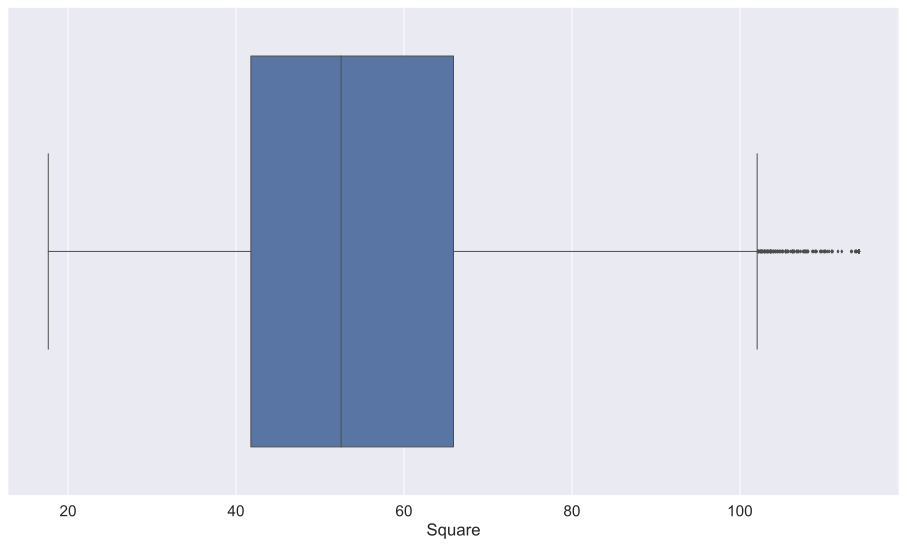

In [39]:
plt.figure(figsize=(16, 9))

sns.boxplot(train_df['Square'],  linewidth=1, fliersize=2, whis=1.5)

plt.xlabel('Square')
plt.show()

In [40]:
train_df['Square'].describe()

count    10000.000000
mean        55.944938
std         17.979907
min         17.649136
25%         41.774881
50%         52.513310
75%         65.900625
max        114.152114
Name: Square, dtype: float64

**KitchenSquare**

4. Странные значения площади кухни: 
  *   мин = 0.0 (?!)
  *   max = 2 014 (?!)

In [41]:
# смотрим на количество встречающихся вариантов площадей кухонь и как часто они встречаются
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

In [42]:
# Смотрим на варианты, когда площадь кухни больше квантиля 97,5. Таких 189 штук
more_0975 = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
train_df.loc[more_0975, ['KitchenSquare', 'Price']]

KitchenSquare          Price
85             14.0  474500.585591
158            16.0  131073.658505
169            14.0  383841.928039
184            14.0  338588.253942
277            22.0  348962.861294
...             ...            ...
9743           20.0  231464.510346
9746           19.0  143688.076514
9810           19.0  137595.610782
9860           25.0  172366.012197
9937           20.0  492943.252891

[189 rows x 2 columns]

In [43]:
# смотрим на варианты когда площадь кухни меньше 3 кв.м. Таких около 3 -х тысяч
less_3 = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] < 3)

In [44]:
train_df.loc[less_3, 'KitchenSquare'].value_counts()

1.0    2460
0.0     697
2.0       4
Name: KitchenSquare, dtype: int64

In [45]:
# посмотрим статистику для таких вариантов
train_df.loc[less_3, ['KitchenSquare', 'Price']].describe()

KitchenSquare          Price
count    3161.000000    3161.000000
mean        0.780766  184460.560227
std         0.416841   81233.410482
min         0.000000   60502.583500
25%         1.000000  131103.958685
50%         1.000000  169188.936898
75%         1.000000  211714.807132
max         2.000000  633233.466570

In [46]:
# сравним с общей статистикой
train_df[['KitchenSquare', 'Price']].describe()

KitchenSquare          Price
count   10000.000000   10000.000000
mean        6.273300  214138.857399
std        28.560917   92872.293865
min         0.000000   59174.778028
25%         1.000000  153872.633942
50%         6.000000  192269.644879
75%         9.000000  249135.462171
max      2014.000000  633233.466570

В результате анализа есть предложение сделать следующее:

In [47]:
# для значений площади кухни больше 13 (а таких 189 штук), присвоим значение площади кухни которое показывает квантиль 75
train_df.loc[more_0975, 'KitchenSquare'] = train_df['KitchenSquare'].quantile(.75)
# для значение площади кухни меньше 3 ( а таких больше 3 000), присвоим значение площади равное значению медианы
# или равным 3.
train_df.loc[less_3, 'KitchenSquare'] = train_df['KitchenSquare'].median()
#train_df.loc[less_3, 'KitchenSquare'] = 3

In [48]:
train_df['KitchenSquare'].value_counts()

6.0     4199
8.0     1306
5.0     1169
10.0    1075
9.0     1032
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
3.0       22
Name: KitchenSquare, dtype: int64

**LifeSquare**

3. Жилая площадь, LifeSquare: 
  *   **Не заполненные значения - есть!**
  *   странные значения минимума: мин = 0.3 (?!)
  *   и максимума: max = 7 480 (?!)
  *   **Нужно проверить есть случаи, когда жилая площадь больше общей!**

In [49]:
# смотрим на общую статистику
train_df['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [50]:
# посчитаем минимальные и максимальные значения для жилой площади.
# минимальное значение примем равным либо квантили = 0.05, либо значению минимума общей площади
min_ls = train_df['Square'].min()
#min_ls = train_df['LifeSquare'].quantile(.05)
# максимальное значение примем равным общей площади
max_ls = train_df['Square']

In [51]:
train_df.loc[train_df['LifeSquare'] < min_ls]

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
15     4328          96      1  36.673407   16.285522            9.0      3   
26     8553          88      3  83.262530    4.769174            6.0     13   
58     2304          94      1  35.562394   17.526726            7.0      8   
63    11630          58      1  30.961868   15.168644            6.0      3   
92     2357          32      1  31.828480   15.222565            5.0      5   
...     ...         ...    ...        ...         ...            ...    ...   
9915   8998          20      1  30.082090   12.125029            7.0      9   
9938   2913          34      4  94.888593    2.637095            6.0      4   
9982  10268          27      1  36.112393    1.855415            6.0      9   
9990  10635          21      1  18.983962   11.419796            6.0      1   
9997   2795         178      1  29.648057   16.555363            5.0      3   

      HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  \
15            12       2003   0.041116          1          1        53   
26             1       1977   0.127376          1          1        43   
58             9       1972   0.282798          1          1        33   
63            12       1973   0.310199          1          1        11   
92             5       1972   0.135650          1          1        46   
...          ...        ...        ...        ...        ...       ...   
9915           9       1976   0.019509          1          1        37   
9938           1       2018   0.069753          1          1        53   
9982          16       1977   0.211401          1          1         9   
9990           5       1967   0.194489          1          1        47   
9997           5       1958   0.460556          1          1        20   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2  \
15       14892         4           NaN            1        4        1   
26        8429         3           NaN            3        9        1   
58        8667         2           NaN            0        6        1   
63        2748         1           NaN            0        0        1   
92        7960         6         350.0            3       11        1   
...        ...       ...           ...          ...      ...      ...   
9915      7687        11         176.0            5        5        1   
9938     13670         4           NaN            1       11        1   
9982      1892         0           NaN            0        1        1   
9990      8004         3         125.0            3        5        1   
9997      4386        14           NaN            1        5        1   

              Price  
15    168143.345700  
26    410883.892020  
58    170703.867259  
63    117941.286753  
92    170343.755036  
...             ...  
9915  186537.391208  
9938  346949.506507  
9982   94881.691800  
9990  112411.221700  
9997  165953.912580  

[388 rows x 20 columns]

In [52]:
train_df.loc[train_df['LifeSquare'] > max_ls]

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
33      847          74      2  73.314975   74.131261            6.0      7   
64     3992           1      3  87.200625   87.730225            6.0     21   
77    11771          45      1  38.467276   39.624493            6.0     11   
100   13343          74      2  79.937665   82.931595            6.0      8   
111   13875          20      1  28.438794   32.514021            6.0      6   
...     ...         ...    ...        ...         ...            ...    ...   
9960  16258          48      3  96.056784   98.152802            6.0     15   
9962  14175          14      1  42.029175   44.682167           10.0      4   
9979   2201           6      1  40.043234   41.984322            6.0      3   
9987  11665           1      2  62.690057   64.602939           10.0     19   
9993   9289           1      3  84.486078   88.931509            6.0      4   

      HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  \
33             6       1977   0.075779          1          1         6   
64            22       1977   0.007122          1          1         1   
77             9       1977   0.195781          1          1        23   
100           21       1977   0.075779          1          1         6   
111           10       2014   0.019509          1          1        37   
...          ...        ...        ...        ...        ...       ...   
9960           1       2017   0.041125          1          1        46   
9962           4       2018   0.238617          1          1        26   
9979          17       2014   0.243205          1          1         5   
9987          22       2018   0.007122          1          1         1   
9993          22       2016   0.007122          1          1         1   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2  \
33        1437         3           NaN            0        2        1   
64         264         0           NaN            0        1        1   
77        5212         6           NaN            3        2        1   
100       1437         3           NaN            0        2        1   
111       7687        11         176.0            5        5        1   
...        ...       ...           ...          ...      ...      ...   
9960      9515         5           NaN            1       10        1   
9962      3889         6         705.0            3        6        1   
9979      1564         0         540.0            0        0        1   
9987       264         0           NaN            0        1        1   
9993       264         0           NaN            0        1        1   

              Price  
33    254005.381863  
64    300180.365669  
77    247440.530601  
100   226808.747168  
111   199248.114376  
...             ...  
9960  524365.550705  
9962   87556.385617  
9979  134888.083598  
9987  203908.192698  
9993  264213.558631  

[489 rows x 20 columns]

In [53]:
# Оптимизируем значения жилой площади, удалив выбросы
# вопрос - имеет ли смысл ввести доп признак - выбросы жилой площади? - Проверить!

In [54]:
# примем значения жилой площади меньше минимального равным минимальному значению
train_df.loc[train_df['LifeSquare'] < min_ls, 'LifeSquare'] = min_ls

In [55]:
# примем значения жилой площади больше максимального равным максимальному значению
train_df.loc[train_df['LifeSquare'] > max_ls, 'LifeSquare'] = max_ls

In [56]:
train_df[['LifeSquare']].describe()

LifeSquare
count  7887.000000
mean     36.263870
std      16.445580
min      17.649136
25%      22.765174
50%      32.760108
75%      45.029599
max     114.152114

Итоговое распределение жилой площади

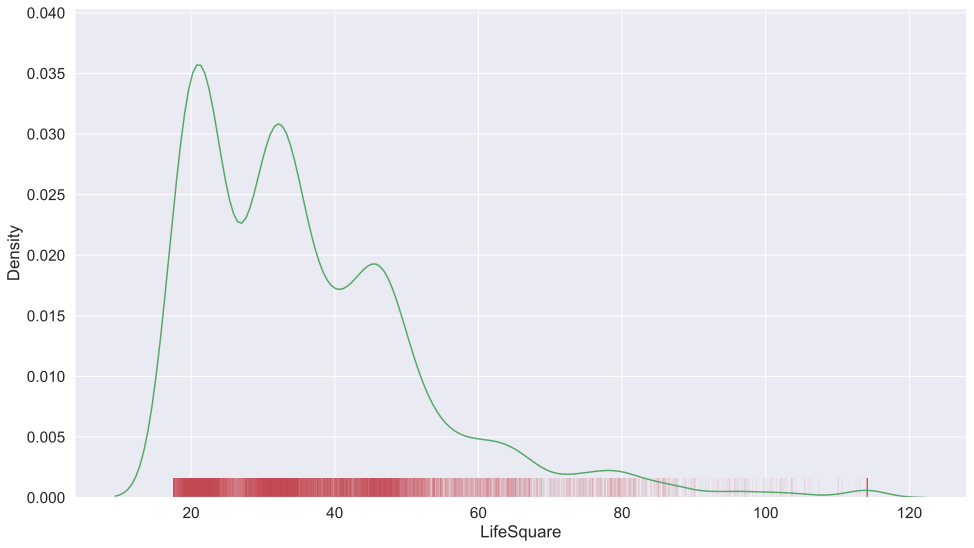

In [57]:
plt.figure(figsize=(16, 9))

h_kws={"alpha": 0.5, "color": "r"}
k_kws={ "shade": False, "color": "g"}
r_kws={"alpha": 0.1, "height":0.04, "color": "r"}
sns.distplot(train_df['LifeSquare'], bins=50, rug=True, hist=False, hist_kws=h_kws, kde_kws=k_kws, rug_kws=r_kws)

plt.xlabel('LifeSquare')
plt.show()

**HouseFloor, Floor**

5. Странные значения этажности дома, HouseFloor:
  *   min = 0
  *   max = 117
  *   **Нужно проверить - есть ли случаи, когда этажность дома меньше, чем этаж квартиры**

In [58]:
# смотрим общую статистику
train_df['HouseFloor'].describe()

count    10000.000000
mean        12.609400
std          6.775974
min          0.000000
25%          9.000000
50%         13.000000
75%         17.000000
max        117.000000
Name: HouseFloor, dtype: float64

In [59]:
# посмотрим, какие вообще значения этажности домов встречаются в наборе
train_df['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  36,  37,  38,  39,  40,  44,
        45,  47,  48,  99, 117])

In [60]:
# посмотрим какие значения этажности квартир встречаются в наборе
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [61]:
# посмотрим на варианты, когда этажность дома меньше 2
train_df.loc[train_df['HouseFloor'] < 2]

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
24     4717          27      1  44.203947         NaN            6.0      2   
25     4521           6      2  65.409965         NaN            6.0     18   
26     8553          88      3  83.262530   17.649136            6.0     13   
44     9024           6      3  79.790762         NaN            6.0     16   
47     6186           1      1  62.006079         NaN            6.0      7   
...     ...         ...    ...        ...         ...            ...    ...   
9938   2913          34      4  94.888593   17.649136            6.0      4   
9940   4711           6      1  41.224118         NaN            6.0      8   
9950   5383          48      3  98.994909         NaN            6.0      3   
9960  16258          48      3  96.056784   96.056784            6.0     15   
9996  16265          27      2  64.307684   37.038420            9.0     13   

      HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  \
24             0       1977   0.072158          1          1         2   
25             1       1977   0.243205          1          1         5   
26             1       1977   0.127376          1          1        43   
44             1       1977   0.243205          1          1         5   
47             1       1977   0.007122          1          1         1   
...          ...        ...        ...        ...        ...       ...   
9938           1       2018   0.069753          1          1        53   
9940           0       1977   0.243205          1          1         5   
9950           0       1977   0.041125          1          1        46   
9960           1       2017   0.041125          1          1        46   
9996           0       1977   0.072158          1          1         2   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2  \
24         629         1           NaN            0        0        0   
25        1564         0         540.0            0        0        1   
26        8429         3           NaN            3        9        1   
44        1564         0         540.0            0        0        1   
47         264         0           NaN            0        1        1   
...        ...       ...           ...          ...      ...      ...   
9938     13670         4           NaN            1       11        1   
9940      1564         0         540.0            0        0        1   
9950      9515         5           NaN            1       10        1   
9960      9515         5           NaN            1       10        1   
9996       629         1           NaN            0        0        0   

              Price  
24    135466.559958  
25    191205.272608  
26    410883.892020  
44    193595.800511  
47    197006.124188  
...             ...  
9938  346949.506507  
9940  125612.639104  
9950  418817.004446  
9960  524365.550705  
9996  199715.148807  

[766 rows x 20 columns]

In [62]:
# посмотрим на варианты когда этажность домовй больше 90 этажей (максимум для Москвы на текущий момент)
train_df.loc[train_df['HouseFloor'] > 90]

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
746    9300          74      2  71.747869   71.747869            9.0      5   
1678     78          30      2  65.773749   65.773749            6.0      8   
4657  10806           5      1  51.944587   48.709601            6.0      6   

      HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  \
746           99       1977   0.075779          1          1         6   
1678         117       1977   0.000078          1          1        22   
4657          99       1977   0.150818          1          1        16   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2  \
746       1437         3           NaN            0        2        1   
1678      6398       141        1046.0            3       23        1   
4657      3433         4        2643.0            4        5        1   

              Price  
746   243329.912579  
1678  207248.370520  
4657  296127.115515

In [63]:
# посмотрим, если ли случаи, когда этаж квартиры больше чем этажность дома?! (таких аж 1825!)
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [64]:
# введем доп признак - выброс по этажности дома
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['HouseFloor'] > 90, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1


In [65]:
# присвоим значения этажности дома для 0 и для > 90 - значение медианы
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()
train_df.loc[train_df['HouseFloor'] > 90, 'HouseFloor'] = train_df['HouseFloor'].median()

In [66]:
# для значений этажей, которые больше этажности дома, присвоим им рандомное значение, не больше этажа дома
# запишем индексы таких домов
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [67]:
# присвоим случайное значение от 1 до этажности дома
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [68]:
# проверка результата
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

**HouseYear**

6. Страные значения года постройки дома:
  *   max = 2.005201e+07 (?!)

In [69]:
# смотрим общую статистику
train_df['HouseYear'].describe()

count    1.000000e+04
mean     3.990166e+03
std      2.005003e+05
min      1.910000e+03
25%      1.974000e+03
50%      1.977000e+03
75%      2.001000e+03
max      2.005201e+07
Name: HouseYear, dtype: float64

In [70]:
# посмотрим на то, какие года постройки дом встречаются
train_df['HouseYear'].sort_values(ascending=False).unique()

array([20052011,     4968,     2020,     2019,     2018,     2017,
           2016,     2015,     2014,     2013,     2012,     2011,
           2010,     2009,     2008,     2007,     2006,     2005,
           2004,     2003,     2002,     2001,     2000,     1999,
           1998,     1997,     1996,     1995,     1994,     1993,
           1992,     1991,     1990,     1989,     1988,     1987,
           1986,     1985,     1984,     1983,     1982,     1981,
           1980,     1979,     1978,     1977,     1976,     1975,
           1974,     1973,     1972,     1971,     1970,     1969,
           1968,     1967,     1966,     1965,     1964,     1963,
           1962,     1961,     1960,     1959,     1958,     1957,
           1956,     1955,     1954,     1953,     1952,     1951,
           1950,     1948,     1947,     1942,     1941,     1940,
           1939,     1938,     1937,     1936,     1935,     1934,
           1933,     1932,     1931,     1930,     1929,     1

Потенциально можно будет попробовать разделить года постройки по группам, и вывести на основе этого новый признак: средняя цена по группам годов постройки

In [71]:
train_df.loc[train_df['HouseYear'] > 2020]

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
8828  11607         147      2  44.791836   28.360393            5.0      4   
9163  10814         109      1  37.265070   20.239714            9.0      9   

      HouseFloor  HouseYear  Ecology_1  ...  Ecology_3  Social_1  Social_2  \
8828           9       4968   0.319809  ...          1        25      4756   
9163          12   20052011   0.136330  ...          1        30      6141   

      Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2          Price  \
8828        16        2857.0            5        8        1  243028.603096   
9163        10         262.0            3        6        1  254084.534396   

      HouseFloor_outlier  
8828                   0  
9163                   0  

[2 rows x 21 columns]

In [72]:
# посмотрим на случаи, когда год постройки больше 2020
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

## 3. Обработка пропусков  <a class='anchor' id='nan'>

In [73]:
# смотрим где у нас есть пропуски и сколько их
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
HouseFloor_outlier       0
dtype: int64

Пропуски есть у двух признаков - LifeSquare и HealthCare_1

**LifeSquare**

In [74]:
# определим дополнительный признак - отсутствие значений жилой площади
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
# заполним пустые значения жилой площади по формуле: Общая площадь - площадь кухни и - 3 кв.м        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

**Healthcare_1**

In [75]:
# Так как пустых значений для признака Healthcare_1 почти половина, то просто удалим этот признак из рассмотрения
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [76]:
train_df.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Helthcare_2           0
Shops_1               0
Shops_2               0
Price                 0
HouseFloor_outlier    0
LifeSquare_nan        0
dtype: int64

## 4. Построение новых признаков  <a class='anchor' id='feature'>

**Dummies**

In [77]:
# посмотрим, какой у нас набор признаков на текущий момент
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  object 
 1   DistrictId          10000 non-null  int64  
 2   Rooms               10000 non-null  int64  
 3   Square              10000 non-null  float64
 4   LifeSquare          10000 non-null  float64
 5   KitchenSquare       10000 non-null  float64
 6   Floor               10000 non-null  int64  
 7   HouseFloor          10000 non-null  int64  
 8   HouseYear           10000 non-null  int64  
 9   Ecology_1           10000 non-null  float64
 10  Ecology_2           10000 non-null  int64  
 11  Ecology_3           10000 non-null  int64  
 12  Social_1            10000 non-null  int64  
 13  Social_2            10000 non-null  int64  
 14  Social_3            10000 non-null  int64  
 15  Helthcare_2         10000 non-null  int64  
 16  Shops

Id и DistrictId - не функциональные признаки, можно их не учитывать в модели. DisctrictId нужно будет учитывать при группировке и созданию новых признаков, например, - средняя цена за квадратный метр в районе.

Признаки Ecology_2, Ecology_3, Shops_2 уже перевели в числовое представление выше

**DistrictSize, IsDistrictLarge**

In [78]:
# посмотрим как часто встречаются предложения в каждом районе. 
train_df['DistrictId'].value_counts().reset_index()

index  DistrictId
0       27         851
1        1         652
2       23         565
3        6         511
4        9         294
..     ...         ...
200    199           1
201    205           1
202    174           1
203    209           1
204    207           1

[205 rows x 2 columns]

In [79]:
# Определим этотна к как размер района - DistrictSize
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

DistrictId  DistrictSize
0          27           851
1           1           652
2          23           565
3           6           511
4           9           294

In [80]:
# приклеим новый признак к общем набору данных
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27      3  114.152114  101.152114           10.0      4   
1   3013          22      1   39.832524   23.169223            8.0      7   
2   8215           1      3   78.342215   47.671972           10.0      2   
3   2352           1      1   40.409907   31.409907            6.0     10   
4  13866          94      2   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1  ...  Social_1  Social_2  Social_3  \
0          10       2014   0.075424  ...        11      3097         0   
1           8       1966   0.118537  ...        30      6207         1   
2          17       1988   0.025609  ...        33      5261         0   
3          22       1977   0.007122  ...         1       264         0   
4          16       1972   0.282798  ...        33      8667         2   

   Helthcare_2  Shops_1  Shops_2          Price  HouseFloor_outlier  \
0            0        0        1  305018.871089                   0   
1            1        0        1  177734.553407                   0   
2            3        1        1  282078.720850                   0   
3            0        1        1  168106.007630                   0   
4            0        6        1  343995.102962                   0   

   LifeSquare_nan  DistrictSize  
0               1           851  
1               0            78  
2               0           652  
3               1           652  
4               0            89  

[5 rows x 22 columns]

In [81]:
# посчитаем сколько записей, когда размер района в пределах 100.
(train_df['DistrictSize'].between(0, 100)).value_counts()

False    5069
True     4931
Name: DistrictSize, dtype: int64

Количество записей, когда размер района в пределах 100 равен примерно половине выборки. Возможно имеет смысл определить дополнительный категориальный признак - насколько район большой.

In [82]:
# введем дополнительный групповой признак - размер района. Пока попробуем разбить на 2 группы: до 100, и больше 100
# как доп вариант можно попробовать разбить на 3 группы: до 100, от 100 до 500, больше 500
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)
train_df.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27      3  114.152114  101.152114           10.0      4   
1   3013          22      1   39.832524   23.169223            8.0      7   
2   8215           1      3   78.342215   47.671972           10.0      2   
3   2352           1      1   40.409907   31.409907            6.0     10   
4  13866          94      2   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1  ...  Social_2  Social_3  Helthcare_2  \
0          10       2014   0.075424  ...      3097         0            0   
1           8       1966   0.118537  ...      6207         1            1   
2          17       1988   0.025609  ...      5261         0            3   
3          22       1977   0.007122  ...       264         0            0   
4          16       1972   0.282798  ...      8667         2            0   

   Shops_1  Shops_2          Price  HouseFloor_outlier  LifeSquare_nan  \
0        0        1  305018.871089                   0               1   
1        0        1  177734.553407                   0               0   
2        1        1  282078.720850                   0               0   
3        1        1  168106.007630                   0               1   
4        6        1  343995.102962                   0               0   

   DistrictSize  IsDistrictLarge  
0           851                1  
1            78                0  
2           652                1  
3           652                1  
4            89                0  

[5 rows x 23 columns]

**MedPriceByDistrict**

In [83]:
# введем дополнительный признак - медианная цена квартир по району и количеству комнат
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

DistrictId  Rooms  MedPriceByDistrict
0           0      1       142799.434052
1           0      2       176210.812334
2           0      3       300610.359425
3           1      1       146735.671740
4           1      2       202666.310126

In [84]:
# приклеим новый признак к общем набору данных
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27      3  114.152114  101.152114           10.0      4   
1   3013          22      1   39.832524   23.169223            8.0      7   
2   8215           1      3   78.342215   47.671972           10.0      2   
3   2352           1      1   40.409907   31.409907            6.0     10   
4  13866          94      2   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1  ...  Social_3  Helthcare_2  Shops_1  \
0          10       2014   0.075424  ...         0            0        0   
1           8       1966   0.118537  ...         1            1        0   
2          17       1988   0.025609  ...         0            3        1   
3          22       1977   0.007122  ...         0            0        1   
4          16       1972   0.282798  ...         2            0        6   

   Shops_2          Price  HouseFloor_outlier  LifeSquare_nan  DistrictSize  \
0        1  305018.871089                   0               1           851   
1        1  177734.553407                   0               0            78   
2        1  282078.720850                   0               0           652   
3        1  168106.007630                   0               1           652   
4        1  343995.102962                   0               0            89   

   IsDistrictLarge  MedPriceByDistrict  
0                1       213530.788443  
1                0       146032.829834  
2                1       244005.272380  
3                1       146735.671740  
4                0       201584.441255  

[5 rows x 24 columns]

**MedPriceByFloorYear**

In [85]:
# определим некоторое количество функций, которые нам могут понадобиться
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [86]:
# добавим еще два категориальных (групповых) признака по году постройки и по этажности квартир
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27      3  114.152114  101.152114           10.0      4   
1   3013          22      1   39.832524   23.169223            8.0      7   
2   8215           1      3   78.342215   47.671972           10.0      2   
3   2352           1      1   40.409907   31.409907            6.0     10   
4  13866          94      2   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1  ...  Shops_1  Shops_2          Price  \
0          10       2014   0.075424  ...        0        1  305018.871089   
1           8       1966   0.118537  ...        0        1  177734.553407   
2          17       1988   0.025609  ...        1        1  282078.720850   
3          22       1977   0.007122  ...        1        1  168106.007630   
4          16       1972   0.282798  ...        6        1  343995.102962   

   HouseFloor_outlier  LifeSquare_nan  DistrictSize  IsDistrictLarge  \
0                   0               1           851                1   
1                   0               0            78                0   
2                   0               0           652                1   
3                   0               1           652                1   
4                   0               0            89                0   

   MedPriceByDistrict  year_cat  floor_cat  
0       213530.788443         6          2  
1       146032.829834         3          3  
2       244005.272380         4          1  
3       146735.671740         3          4  
4       201584.441255         3          5  

[5 rows x 26 columns]

In [87]:
# сгруппируем по группам года и этажности значение цены, и создадим новый признак равный медиане цены в группе
# Возможно неплохая идея  создать два разных признака: медиана цены по группе года постройки и медиана по группе этажности
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

year_cat  floor_cat  MedPriceByFloorYear
0         1          1        371270.130631
1         1          2        324303.812481
2         1          3        421756.290145
3         1          4        274992.472366
4         2          1        467230.539057

In [88]:
# приклеим новый признак медианнное значение по году постройки и по этажности квартир к общем набору данных
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27      3  114.152114  101.152114           10.0      4   
1   3013          22      1   39.832524   23.169223            8.0      7   
2   8215           1      3   78.342215   47.671972           10.0      2   
3   2352           1      1   40.409907   31.409907            6.0     10   
4  13866          94      2   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1  ...  Shops_2          Price  \
0          10       2014   0.075424  ...        1  305018.871089   
1           8       1966   0.118537  ...        1  177734.553407   
2          17       1988   0.025609  ...        1  282078.720850   
3          22       1977   0.007122  ...        1  168106.007630   
4          16       1972   0.282798  ...        1  343995.102962   

   HouseFloor_outlier  LifeSquare_nan  DistrictSize  IsDistrictLarge  \
0                   0               1           851                1   
1                   0               0            78                0   
2                   0               0           652                1   
3                   0               1           652                1   
4                   0               0            89                0   

   MedPriceByDistrict  year_cat  floor_cat  MedPriceByFloorYear  
0       213530.788443         6          2        161974.797753  
1       146032.829834         3          3        192048.442631  
2       244005.272380         4          1        202046.143358  
3       146735.671740         3          4        183505.979560  
4       201584.441255         3          5        173934.865013  

[5 rows x 27 columns]

## 6. Определение функций и классов

В функциях и классах набор новых признаков и способов очистки может отличаться от того, что было выше.

In [89]:
# функция для анализа результатов предсказания на тренировочном и валидационном датасете
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test prediction')

    plt.show()

In [90]:
# класс для предварительной обработки данных: обработка выбросов и пустых значений, 
# а также замена категориальных переменных на бинарные
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.mins = None
        self.kitchen_square_quantile_975 = None
        self.kitchen_square_quantile_75 = None
        self.max_square_quantile = None
        self.min_square_quantile = None
        self.max_lifesquare = None
        self.min_lifesquare = None
        self._whis, self._dev = 1.5, 0.5
        
    def fit(self, X):  
        """Сохранение статистик и необходимых переменных"""   
                
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}

        # Расчет медиан и прочих статистических переменных
        self.medians = X.median()
        self.mins = X.min()
        self.kitchen_square_quantile_975 = X['KitchenSquare'].quantile(.975)
        self.kitchen_square_quantile_75 = X['KitchenSquare'].quantile(.75)
        # посчитаем межквартильный размах для общей площади, и максимальное и минимальное значения (значения "усов")
        quart_range = X['Square'].quantile(.75) - X['Square'].quantile(.25)
        self.max_square_quantile = X['Square'].quantile(.75) + (quart_range * (self._whis + self._dev))
        #self.max_square_quantile = 200
        self.min_square_quantile = X['Square'].quantile(.25) - (quart_range * (self._whis - self._dev))
        
        # определим минимальное значение для жилой площади
        # посчитаем минимальные и максимальные значения для жилой площади.
        # минимальное значение примем равным либо квантили = 0.05, либо значению минимума общей площади
        #self.max_lifesquare = None
        #self.min_lifesquare = self.mins['Square']
        self.min_lifesquare =  X['LifeSquare'].quantile(.05)     
    
    def transform(self, X):
        """Трансформация данных"""
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
      
        ## Rooms
          # вариант: присвоение значения медианы для выбросов
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms'] = self.medians['Rooms'] 
          # вариант: присвоение разных значений для 0 и больше 6.
          # X.loc[X['Rooms'] == 0, 'Rooms'] = 1
          # X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        ## KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile_975)
        
          # для значений площади кухни больше 13 (а таких 189 штук), присвоим значение площади кухни которое показывает квантиль 75
        X.loc[condition, 'KitchenSquare'] = self.kitchen_square_quantile_75
          # альтернативный вариант
          #X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

          # для значение площади кухни меньше 3 ( а таких больше 3 000), присвоим значение площади равное значению медианы
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = self.medians['KitchenSquare']
          # или равным 3.
          #X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        ## Square
          # Присвоим значение общей площади для значений выше 200 = 200 или 
          # Присвоим значение общей площади для значений, выше 2х межквартильных размахов = значению максимального 2* межквартильного размаха
          #X.loc[(X['Square'] > 200), 'Square'] = 200
        X.loc[(X['Square'] > self.max_square_quantile), 'Square'] = self.max_square_quantile
          # альтернативный вариант присвоить значение медианы
          #X.loc[(X['Square'] > 200), 'Square'] = self.medians['Square']
          #X.loc[(X['Square'] > self.max_square_quantile), 'Square'] = self.medians['Square']

          # Присвоим значение общей площади для значений меньше 20 = 20
          # Присвоим значение общей площади для значений меньше минимум от одного межквартильного размаха
          # train_df.loc[(train_df['Square'] < 20), 'Square'] = 20
        X.loc[(X['Square'] < self.min_square_quantile), 'Square'] = self.min_square_quantile


        ## HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] > 90, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1

          # присвоим значения этажности дома для 0 и для > 90 - значение медианы     
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['HouseFloor'] > 90, 'HouseFloor'] = self.medians['HouseFloor']

          # для значений этажей, которые больше этажности дома, присвоим им рандомное значение, не больше этажа дома
          # запишем индексы таких домов
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        ## HouseYear
        current_year = datetime.now().year
        
        # введем новый признак
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        # присвоим значение текущего года, годам постройки больше текущего
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        

        ## Healthcare_1
          # слишком много пустых значений - просто удалим признак
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
          # как альтернатива - можно вычислить его значение
            

        ## LifeSquare

          # Оптимизируем значения жилой площади, удалив выбросы
          # вопрос - имеет ли смысл ввести доп признак - выбросы жилой площади? - Проверить!

          # значения жилой площади меньше минимального примем равным минимальному значению
        X.loc[X['LifeSquare'] < self.min_lifesquare, 'LifeSquare'] = self.min_lifesquare
          # максимальное значение примем равным общей площади
        max_ls = X['Square']
          # значения жилой площади больше максимального примем равным максимальному значению
        #X.loc[X['LifeSquare'] > max_ls, 'LifeSquare'] = max_ls
          # как альтернатива - сделаем так же как и для пустых значений
        X.loc[X['LifeSquare'] > X['Square'], 'LifeSquare'] = X.loc[~X['Square'].isna(),\
                                                                   'Square'] - X.loc[~X['KitchenSquare'].isna(), 'KitchenSquare'] -3

          # пустые значения заполним вычислив жилую площадь как разницу общей и кухни минус постоянную
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3

        ## если остались пустые значения, заполним их соответствующей медианой
        X.fillna(self.medians, inplace=True)
        
        return X
            

In [91]:
class FeatureGenetator():
    """Генерация новых признаков"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None

        self.mean_price_unit_by_district = None
        self.mean_price_unit_by_district_mean = None

        self.med_price_by_district = None
        self.med_price_by_floor_year = None

        self.med_price_by_social_1 = None
        self.med_price_by_disctrict_social_1 = None
        self.med_price_by_social_2 = None
        self.med_price_by_disctrict_social_2 = None
        self.med_price_by_health_2 = None
        self.med_price_by_district_health_2 = None
        self.med_price_by_shops_1 = None
        self.med_price_by_disctrict_shops_1 = None

        self.mean_price_by_floor = None
        self.mean_price_by_floor_mean = None

        self.mean_price_by_year = None

        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        # Новый признак - DistrictSize
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            # вычисление средней (медианной) цены за 1,2,3 и тд комнатные квартиры по району
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
            # вычисление медианной цены по признаку social_1
            self.med_price_by_social_1 = df.groupby(['Social_1'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceBySocial_1'})
            
            self.med_price_by_social_1_median = self.med_price_by_social_1['MedPriceBySocial_1'].median()

            # вычисление медианной цены по признаку social_2
            self.med_price_by_social_2 = df.groupby(['Social_2'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceBySocial_2'})
            
            self.med_price_by_social_2_median = self.med_price_by_social_2['MedPriceBySocial_2'].median()

            # вычисление медианной цены по признаку Helthcare_2
            self.med_price_by_health_2 = df.groupby(['Helthcare_2'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByHealthCare_2'})
            
            self.med_price_by_health_2_median = self.med_price_by_health_2['MedPriceByHealthCare_2'].median()

            # вычисление медианной цены по признаку Shops_1
            self.med_price_by_shops_1 = df.groupby(['Shops_1'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByShops_1'})
            
            self.med_price_by_shops_1_median = self.med_price_by_shops_1['MedPriceByShops_1'].median()

            # вычисление медианной цены по признаку social_1 в районе
            self.med_price_by_disctrict_social_1 = df.groupby(['DistrictId', 'Social_1'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrictBySocial_1'})
            self.med_price_by_disctrict_social_1_median = self.med_price_by_disctrict_social_1['MedPriceByDistrictBySocial_1']\
                                            .median()  

            # вычисление медианной цены по признаку social_2 в районе
            self.med_price_by_disctrict_social_2 = df.groupby(['DistrictId', 'Social_2'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrictBySocial_2'})
            self.med_price_by_disctrict_social_2_median = self.med_price_by_disctrict_social_2['MedPriceByDistrictBySocial_2']\
                                            .median() 

            # вычисление медианной цены по признаку Helthcare_2 в районе
            self.med_price_by_disctrict_health_2 = df.groupby(['DistrictId', 'Helthcare_2'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrictByHealthCare_2'})
            self.med_price_by_disctrict_health_2_median = self.med_price_by_disctrict_health_2['MedPriceByDistrictByHealthCare_2']\
                                            .median() 

            # вычисление медианной цены по признаку shops_1 в районе
            self.med_price_by_disctrict_shops_1 = df.groupby(['DistrictId', 'Shops_1'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrictByShops_1'})
            self.med_price_by_disctrict_shops_1_median = self.med_price_by_disctrict_shops_1['MedPriceByDistrictByShops_1']\
                                            .median()  

            # вычисление средней цены за квадратный метр по району
            df['unit_price'] = df['Price']/df['Square']

            self.mean_price_unit_by_district = df.groupby(['DistrictId'], as_index=False).agg({'unit_price':'mean'})\
                                                  .rename(columns={'unit_price': 'MeanUnitPriceByDistrict'})
            self.mean_price_unit_by_district_mean = self.mean_price_unit_by_district['MeanUnitPriceByDistrict'].mean()


            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            # вычисление по комбинированному принаку - группы этажности и годов постройки
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            
            # вычисление средней цены по группам этажности
            self.mean_price_by_floor = df.groupby(['floor_cat'], as_index=False).agg({'Price':'mean'}).\
                                            rename(columns={'Price':'MeanPriceByFloor'})
            self.mean_price_by_floor_mean = self.mean_price_by_floor['MeanPriceByFloor'].mean()
            
            # вычисление средней цены по группам годов постройки
            self.mean_price_by_year = df.groupby(['year_cat'], as_index=False).agg({'Price':'mean'}).\
                                            rename(columns={'Price':'MeanPriceByYear'})
            self.mean_price_by_year_mean = self.mean_price_by_year['MeanPriceByYear'].mean()  


    def transform(self, X):
        
        # DistrictSize, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        # если возникли пустые значения, заполним их
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        # если после преобразования появятся пустые значения, будем заполнять их медианным значением
        # средняя (медианная) цена одно, двух, трех и тд комнатных квартир по району
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
        # средняя цена квадратного метра по району
        if  self.mean_price_unit_by_district is not None:
          X = X.merge(self.mean_price_unit_by_district, on= ['DistrictId'], how='left')
          X.fillna(self.mean_price_unit_by_district_mean, inplace=True)
        # средняя (медианная) цена на квартиру по группам этажей и годов постройки
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        # средняя цена по группам годов постройки
        if self.mean_price_by_year is not None:
            X = X.merge(self.mean_price_by_year, on=['year_cat'], how='left')
            X.fillna(self.mean_price_by_year_mean, inplace=True)        
        # среднняя цена по группам этажности квартир
        if self.mean_price_by_floor is not None:
            X = X.merge(self.mean_price_by_floor, on=['floor_cat'], how='left')
            X.fillna(self.mean_price_by_floor_mean, inplace=True)
        # средняя цена по social_1
        if self.med_price_by_social_1 is not None:
            X = X.merge(self.med_price_by_social_1, on=['Social_1'], how='left')
            X.fillna(self.med_price_by_social_1_median, inplace=True)
        # средняя цена по social_1 в районе
        if self.med_price_by_disctrict_social_1 is not None:
            X = X.merge(self.med_price_by_disctrict_social_1, on=['DistrictId', 'Social_1'], how='left')
            X.fillna(self.med_price_by_disctrict_social_1_median, inplace=True)
        # средняя цена по social_2
        if self.med_price_by_social_2 is not None:
            X = X.merge(self.med_price_by_social_2, on=['Social_2'], how='left')
            X.fillna(self.med_price_by_social_2_median, inplace=True)
        # средняя цена по social_2 в районе
        if self.med_price_by_disctrict_social_2 is not None:
            X = X.merge(self.med_price_by_disctrict_social_2, on=['DistrictId', 'Social_2'], how='left')
            X.fillna(self.med_price_by_disctrict_social_2_median, inplace=True)
        # средняя цена по Helthcare_2
        if self.med_price_by_health_2 is not None:
            X = X.merge(self.med_price_by_health_2, on=['Helthcare_2'], how='left')
            X.fillna(self.med_price_by_health_2_median, inplace=True)
        # средняя цена по Helthcare_2 в районе
        if self.med_price_by_disctrict_health_2 is not None:
            X = X.merge(self.med_price_by_disctrict_health_2, on=['DistrictId', 'Helthcare_2'], how='left')
            X.fillna(self.med_price_by_disctrict_health_2_median, inplace=True)  
        # средняя цена по shop_1
        if self.med_price_by_shops_1 is not None:
            X = X.merge(self.med_price_by_shops_1, on=['Shops_1'], how='left')
            X.fillna(self.med_price_by_shops_1_median, inplace=True)
        # средняя цена по shop_1 в районе
        if self.med_price_by_disctrict_shops_1 is not None:
            X = X.merge(self.med_price_by_disctrict_shops_1, on=['DistrictId', 'Shops_1'], how='left')
            X.fillna(self.med_price_by_disctrict_shops_1_median, inplace=True)  

        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)

        return X


## 7. Разбиение на train и test

In [92]:
# Загружаем заново наши наборы данных
target_name = 'Price'
train_df = pd.read_csv(TRAIN_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [93]:
"""
# этот код нужно запускать, чтобы взять вычисления train_df которые были сделаны в ячейках до 7 го раздела.
# то есть по ходу ноутбука это текущее состояние train_df - данные очищены, признаки построены в исследовательском режиме
target_name = 'Price'
X = train_df.drop(columns=target_name)
y = train_df[target_name]
"""

"\n# этот код нужно запускать, чтобы взять вычисления train_df которые были сделаны в ячейках до 7 го раздела.\n# то есть по ходу ноутбука это текущее состояние train_df - данные очищены, признаки построены в исследовательском режиме\ntarget_name = 'Price'\nX = train_df.drop(columns=target_name)\ny = train_df[target_name]\n"

In [94]:
# разбиваем набор данных на тренировочный и валидационный
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [95]:
# проведем очистку и подготовку данных, кроме генерации доп. признаков
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)
# подготовка и вычисление необходимых перемнных
preprocessor.fit(X)

# трансформация данных
X_train = preprocessor.transform(X_train)
###X = preprocessor.transform(X)
X_valid = preprocessor.transform(X_valid)

X_train.shape, X_valid.shape

((6700, 21), (3300, 21))

In [96]:
# добавим новые признаки
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)
###features_gen.fit(X, y)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)

X_train.shape, X_valid.shape

((6700, 39), (3300, 39))

## 5. Отбор признаков  <a class='anchor' id='feature_selection'>

In [97]:
X_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'new_district',
 'IsDistrictLarge',
 'floor_cat',
 'year_cat',
 'MedPriceByDistrict',
 'MeanUnitPriceByDistrict',
 'MedPriceByFloorYear',
 'MeanPriceByYear',
 'MeanPriceByFloor',
 'MedPriceBySocial_1',
 'MedPriceByDistrictBySocial_1',
 'MedPriceBySocial_2',
 'MedPriceByDistrictBySocial_2',
 'MedPriceByHealthCare_2',
 'MedPriceByDistrictByHealthCare_2',
 'MedPriceByShops_1',
 'MedPriceByDistrictByShops_1']

In [98]:
"""
# базовый набор
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']
"""
feature_names = ['Rooms', 
                 'Square', 
                 'LifeSquare', 
                 'KitchenSquare', 
                 #'Floor', 
                 'HouseFloor', 
                 'HouseYear',
                 'Ecology_1', 
                 'Ecology_2', 
                 'Ecology_3', 
                 'Social_1', 
                 #'Social_2', 
                 'Social_3',
                 'Helthcare_2', 
                 'Shops_1', 
                 'Shops_2'
                 ]

new_feature_names = [
                     #'Rooms_outlier', 
                     'HouseFloor_outlier', 
                     #'HouseYear_outlier', 
                     'LifeSquare_nan', 
                     'DistrictSize',
                     #'new_district', 
                     'IsDistrictLarge',  
                     #'MedPriceByDistrict', 
                     'MedPriceByFloorYear', 
                     'MeanUnitPriceByDistrict', 
                     'MeanPriceByFloor', 
                     #'MeanPriceByYear', 
                     #'MedPriceBySocial_1', 
                     #'MedPriceByDistrictBySocial_1',
                     #'MedPriceBySocial_2' ,
                     #'MedPriceByDistrictBySocial_2', 
                     #'MedPriceByHealthCare_2', 
                     #'MedPriceByDistrictByHealthCare_2',
                     #'MedPriceByShops_1', 
                     #'MedPriceByDistrictByShops_1'
                     ]


# new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'LifeSquare_nan']


In [99]:
# для обучения модели будем брать не все признаки, а только эти:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]


## 8. Построение модели

**Обучение**

In [100]:
# посмотрим на каких признаках будем обучать модель
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6700 entries, 0 to 6699
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Rooms                    6700 non-null   float64
 1   Square                   6700 non-null   float64
 2   LifeSquare               6700 non-null   float64
 3   KitchenSquare            6700 non-null   float64
 4   HouseFloor               6700 non-null   float64
 5   HouseYear                6700 non-null   int64  
 6   Ecology_1                6700 non-null   float64
 7   Ecology_2                6700 non-null   int64  
 8   Ecology_3                6700 non-null   int64  
 9   Social_1                 6700 non-null   int64  
 10  Social_3                 6700 non-null   int64  
 11  Helthcare_2              6700 non-null   int64  
 12  Shops_1                  6700 non-null   int64  
 13  Shops_2                  6700 non-null   int64  
 14  HouseFloor_outlier      

In [101]:
# создаем экземпляр модели с предварительно вычисленными гиперпараметрами
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=15, # глубина дерева  
                                 min_samples_leaf=1, # минимальное кол-во наблюдений в листе дерева
                                 random_state=21,
                                 max_features=13,
                                 n_estimators=200  # кол-во деревьев
                                 )
# и обучаем ее
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, max_features=13, n_estimators=200,
                      random_state=21)

**Оценка**

Train R2:	0.954
Test R2:	0.753


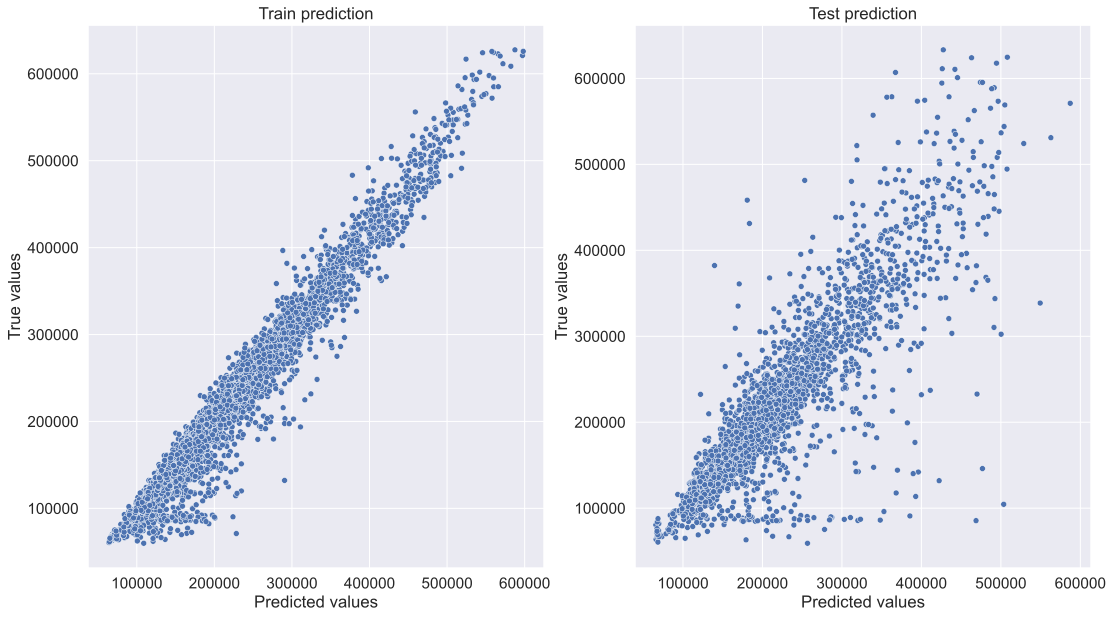

In [102]:
# Делаем предсказания на тренировочном и валидационном наборах данных
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [103]:
# проведем кросс-валидацию
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.78218063, 0.73045108, 0.74846988, 0.7472632 , 0.75095648])

In [104]:
cv_score.mean()

0.7518642515830306

**Важность признаков**

In [105]:
# проанализируем какие признаки дали наибольший и наименьший вклад в оценку
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances['importance'] = feature_importances['importance'].apply(lambda x: "%.6f" % x)
feature_importances.sort_values(by='importance', ascending=False)

feature_name importance
1                    Square   0.334870
19  MeanUnitPriceByDistrict   0.250095
0                     Rooms   0.099653
16             DistrictSize   0.062543
2                LifeSquare   0.058479
18      MedPriceByFloorYear   0.027347
9                  Social_1   0.026138
5                 HouseYear   0.024453
10                 Social_3   0.020407
4                HouseFloor   0.019644
6                 Ecology_1   0.016792
3             KitchenSquare   0.015397
17          IsDistrictLarge   0.012067
12                  Shops_1   0.011928
20         MeanPriceByFloor   0.007506
11              Helthcare_2   0.006856
14       HouseFloor_outlier   0.002280
13                  Shops_2   0.001271
15           LifeSquare_nan   0.001261
8                 Ecology_3   0.000842
7                 Ecology_2   0.000172

## 9. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [106]:
# загрузим тестовый набор данных
test_df = pd.read_csv(TEST_DATASET_PATH)


In [107]:
test_df.shape

(5000, 19)

In [108]:
test_df.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  4567          44    1.0  36.847630   19.094182            5.0      5   
1  5925          62    1.0  42.493907   42.568133           10.0      7   
2   960          27    2.0  59.463678         NaN            9.0     19   
3  3848          23    3.0  49.646030   33.893825            6.0      2   
4   746          74    1.0  53.837056         NaN            1.0      8   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1970   0.036122         B         B        24      4378   
1        17.0       2017   0.072158         B         B         2       629   
2        19.0       1977   0.211401         B         B         9      1892   
3         2.0       1965   0.014073         B         B         2       475   
4        17.0       1977   0.309479         B         B        35      7715   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
0         0        1036.0            1        1       B  
1         1           NaN            0        0       A  
2         0           NaN            0        1       B  
3         0           NaN            0        0       B  
4         4         990.0            0        6       B

In [109]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Проводим подготовку данных и генерацию новых признаков

In [110]:
# готовим тренировочный набор данных
train_df = pd.read_csv(TRAIN_DATASET_PATH)
target_name = 'Price'
X = train_df.drop(columns=target_name)
y = train_df[target_name]

# проведем очистку и подготовку данных, кроме генерации доп. признаков
preprocessor = DataPreprocessing()
## подготовка и вычисление необходимых переменных на тренировочном наборе данных
preprocessor.fit(X)
## Очистка данных на тестовом наборе данных
test_df = preprocessor.transform(test_df)

# добавим новые признаки
features_gen = FeatureGenetator()
# вычислим все необходимые переменные на тренировочном наборе данных
features_gen.fit(X, y)
# добавим новые признаки на тестовом наборе данных
test_df = features_gen.transform(test_df)

In [111]:
# В последующем, для генерации итогового файла понадобится Id
test_df = test_df.set_index('Id')
# Для предсказаний будем использовать только те признаки, на которых обучилась модель
test_df = test_df[feature_names + new_feature_names]

Получаем предсказания на обученной ранее модели данных

In [112]:
predictions = rf_model.predict(test_df)
predictions

array([159449.67982364, 121637.89256786, 159611.48219467, ...,
       156361.0520315 , 184072.65943909, 267204.06855096])

In [113]:
test_df['Price'] = predictions
test_df.head()

Rooms     Square  LifeSquare  KitchenSquare  HouseFloor  HouseYear  \
Id                                                                         
4567    1.0  36.847630   19.094182            5.0         9.0       1970   
5925    1.0  42.493907   29.493907           10.0        17.0       2017   
960     2.0  59.463678   47.463678            9.0        19.0       1977   
3848    3.0  49.646030   33.893825            6.0         2.0       1965   
746     1.0  53.837056   44.837056            6.0        17.0       1977   

      Ecology_1  Ecology_2  Ecology_3  Social_1  ...  Shops_1  Shops_2  \
Id                                               ...                     
4567   0.036122          1          1        24  ...        1        1   
5925   0.072158          1          1         2  ...        0        0   
960    0.211401          1          1         9  ...        1        1   
3848   0.014073          1          1         2  ...        0        1   
746    0.309479          1          1        35  ...        6        1   

      HouseFloor_outlier  LifeSquare_nan  DistrictSize  IsDistrictLarge  \
Id                                                                        
4567                   0               0         104.0                1   
5925                   0               0         247.0                1   
960                    0               1         851.0                1   
3848                   0               0         565.0                1   
746                    0               1         114.0                1   

      MedPriceByFloorYear  MeanUnitPriceByDistrict  MeanPriceByFloor  \
Id                                                                     
4567        187992.360093              4572.483767     207660.889448   
5925        179351.012947              2818.749357     217024.231107   
960         181281.815896              2912.252253     235448.350096   
3848        177933.328473              2284.108677     195898.789890   
746         188098.168461              3355.343060     217024.231107   

              Price  
Id                   
4567  159449.679824  
5925  121637.892568  
960   159611.482195  
3848  125626.839335  
746   174140.705756  

[5 rows x 22 columns]

In [114]:
test_df[['Price']].to_csv('rf_predict2021-04-12-1.csv', index=True)